In [1]:
%load_ext autoreload
%autoreload 2

import cstrees.cstree as ct
import numpy as np
import networkx as nx
import logging, sys
import cstrees.scoring as sc

logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)

# CStree from Figure 1 in (Duarte & Solus, 2022)


In [37]:
a=np.array([[1,2],[3,4]])
a[:, [1,0]].as_list()

AttributeError: 'numpy.ndarray' object has no attribute 'as_list'

In [40]:
a = [1,3,45,5]
a[[1,1,1,1]]


TypeError: list indices must be integers or slices, not list

[[1 0 0 0]
 [0 0 1 1]
 [1 0 1 0]
 [0 1 1 0]
 [1 1 0 1]
 [0 0 1 0]
 [0 0 1 1]
 [1 1 0 0]
 [1 1 0 0]
 [0 0 1 1]]
level 0
[]: {1: 5, 0: 5}
level 1
[1]: {0: 2, 1: 3}
[0]: {0: 4, 1: 1}
level 2
[{0, 1}, 0]: {0: 1, 1: 5}
[0, 1]: {1: 1}
[1, 1]: {0: 3}
level 3
[1, {0, 1}, 0]: {0: 3, 1: 1}
[0, {0, 1}, 1]: {1: 3, 0: 2}
[1, 0, 1]: {0: 1}
-81.21092407394568


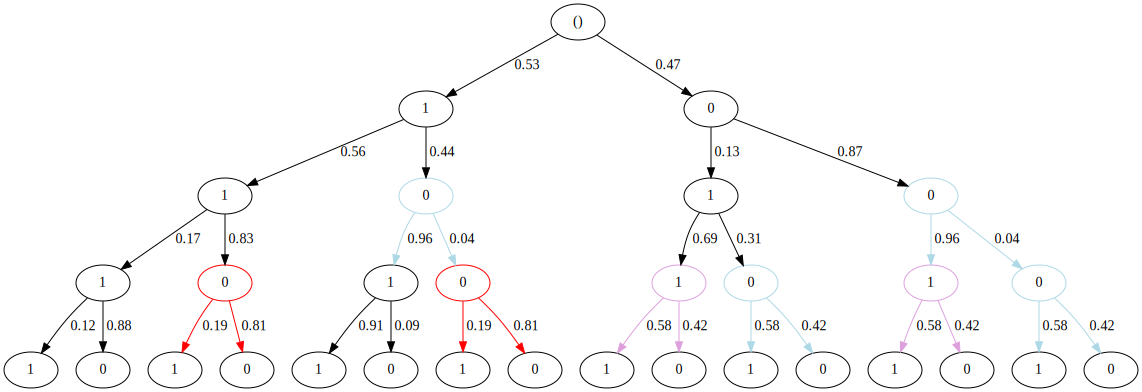

In [2]:
np.random.seed(2)
levelplus1=4
cards = [2] * levelplus1
co = ct.CausalOrder(range(levelplus1))
tree = ct.CStree(co)


#stage = ct.sample_random_stage(cards,2)
#stage.set_random_params(cards)

tree.set_cardinalities(cards)

# These do not have to be in a dict like this as the levels are
# determined from the length of the tuples.

tree.set_stages({
    0: [],
    1: [ct.Stage([{0, 1}, 0])],    # Green
    2: [ct.Stage([0, {0, 1}, 0]),  # Blue
        ct.Stage([0, {0, 1}, 1]),  # Orange
        ct.Stage([1, {0, 1}, 0])]  # Red
})


tree.set_random_stage_parameters()


a = tree.plot()
a.draw("testplot.png")
x = tree.sample(10)

#x = tree.sample(5)
print(x)

s = sc.score(tree, x, alpha_tot=1.0, method="K2")
print(s)
#rels = tree.csi_relations()

#print("Initial rels")
#print(rels)
adjmats = tree.to_minimal_context_graphs()

for key, graph in adjmats.items():
    agraph = nx.nx_agraph.to_agraph(graph)
    agraph.layout("dot")
    agraph.draw(str(key) + "_csi.png", args='-Glabel="'+str(key)+'"   ')
a

In [17]:
tree.to_df()

,0,1,2,3
0,2,2,2,2
0,*,0,-,-
0,0,*,0,-
0,0,*,1,-
0,1,*,0,-


In [4]:
cards = [2] * levelplus1
order = list(range(levelplus1))
order

score = sc.score_order(order, cards, x, max_cvars=1, alpha_tot=1.0, method="K2")

-27.077291331437976
[{0, 1}]
-54.15458266287595
level: 0
cvar level: 0
value to use as contexts: [0, 1]
Staging
stage: [0]
stage: [1]
-81.23187399431393
value to use as contexts: [0]
Staging
stage: [0]
-108.3091653257519
value to use as contexts: [1]
Staging
stage: [1]
-135.38645665718988
value to use as contexts: []
only singletons -> skip
level: 1
cvar level: 0
value to use as contexts: [0, 1]
Staging
stage: [0, {0, 1}]
stage: [1, {0, 1}]
-154.20791956134605
value to use as contexts: [0]
Staging
stage: [0, {0, 1}]
-173.02938246550218
value to use as contexts: [1]
Staging
stage: [1, {0, 1}]
-191.85084536965832
value to use as contexts: []
only singletons -> skip
cvar level: 1
value to use as contexts: [0, 1]
Staging
stage: [{0, 1}, 0]
stage: [{0, 1}, 1]
-210.67230827381445
value to use as contexts: [0]
Staging
stage: [{0, 1}, 0]
-229.4937711779706
value to use as contexts: [1]
Staging
stage: [{0, 1}, 1]
-248.31523408212672
value to use as contexts: []
only singletons -> skip
level: 2
